In [22]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
%matplotlib inline

V_MP = 0.03
V_REST = -0.065

class Hopfield:
    def __init__(self, size=64, iter=10):
        self.iter = iter
        self.size = size
        self.W = np.zeros((size ** 2, size ** 2))

    def train(self, X):
        n = self.size ** 2
        for x in X:  # (-1,64*64)
            x = np.reshape(x, (n, 1))
            xT = np.reshape(x, (1, n))
            self.W += x * xT / n
            
        self.W[np.diag_indices_from(self.W)] = 0

    def test_one_frame(self, x):
        n = self.size ** 2
        x = np.reshape(x, (n,))
        energy = []
        for iter in range(self.iter):
            h = np.zeros((n,))
            for i in range(n):
                i = np.random.randint(n)
                h[i] = self.W[i, :].dot(x)
                # print(i)
            
            x[h > 0] = 1
            x[h < 0] = -1
            energy.append(self.cal_energy(x))

        return np.resize(x, (self.size, self.size)), energy

    def cal_energy(self, x):
        n = self.size ** 2
        energy = np.sum(self.W.dot(x) * x)
        
        return -0.5 * energy

def show(x):
    img = np.where(x > 0, 255, 0).astype(np.uint8)
    cv.imshow("img", img)
    cv.waitKey(0)

class mIZH(Hopfield):
    def __init__(self, size=64, iter=5):
        super().__init__(size, iter)
        self.a1 = 0.04
        self.a2 = 5.0
        self.a3 = 140.0
        self.a4 = 1.0
        self.a5 = 1.0
        self.r = 0.02
            
    def test_one_frame(self, x):      
        
        n = self.size ** 2
        x = np.reshape(x, (n,))
        il = np.zeros(n)
        il.astype(float)
        u = il.copy()
        
        il_new = il.copy()
        u_new = u.copy()
        x = np.reshape(x,(n,1)) 
        x_new = x.copy() 
        
        energy = []
        # 迭代遍历。
        for _ in range(self.iter):
            # 更新x矩阵
            # 对每个x矩阵均进行更新。
            # TODO: 用一个新的x矩阵来进行存储。 Done.
            # 先对x_new进行计算。x不动。
            for i in range(len(u)):
                iext = 0;
                for j in range(self.size):
                    iext += self.W[i][j]*x[j]
                il_new[i] = il[i]+self.r*((self.a1*u[i]+self.a2) * u[i] + self.a3 - il[i])
                # u[i] = u[i] + (self.a1*u[i]+self.a2) * u[i]+self.a3-self.a4*il[i] + self.a5 * iext[i]
                u_new[i] = u[i] + (self.a1*u[i]+self.a2) * u[i]+self.a3-self.a4*il[i] + self.a5 * iext
                
                if abs(u_new[i]-V_REST) < 1e-5: # 浮点误差
                    x_new[i] = x[i]
                else:
                    if u_new[i] > V_MP:
                        x_new[i] = 1;
                    else:
                        x_new[i] = -1;
            # 该轮迭代完成，更新x, u, il。
            x = x_new.copy()
            u = u_new.copy()
            il = il_new.copy()
            energy.append(self.cal_energy(x_new))
            # energy.append(0)
        # return X[-1]
        return np.resize(x_new, (self.size, self.size)), energy
        

这是一个markdown模板

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:86: RuntimeWarning: overflow encountered in double_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:88: RuntimeWarning: overflow encountered in double_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in double_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in double_scalars


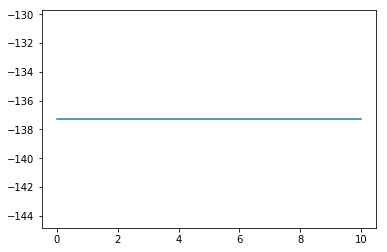

In [24]:
if __name__ == "__main__":

    img = cv.imread(r"D:\resource\mizh\kazuma.jpg", 0)
    size = 40
    img = cv.resize(img, (size, size))
    x = np.where(img > 255 / 2.5, 1, -1)
    x_masked = x.copy()
    x_masked[size // 2:, :] = -1
    img2  = cv.imread(r"D:\resource\mizh\fnn.jpg", 0)
    img2 =  cv.resize(img2, (size, size))
    x2 = np.where(img2 > 255 / 2.5, 1, -1)
    x_masked2 = x2.copy()
    x_masked2[size // 2:, :] = -1
    # show(x_masked)
    
    model =mIZH(size = size, iter=11)
    model.train([x])
    # y0 = model.train([x_masked2])
    # y0 = np.reshape(y0, (size,size))
    y, energy = model.test_one_frame(x_masked)
    show(y)
    plt.plot(energy, label='energy')
    plt.show()
    